# Practice Use Case

**Foundation of Data Engineering**<br>
**Author: Andreas Nugroho R**<br>
**Date: 31 October 2019**

In [ ]:
import pandas as pd 
import numpy as np

#Authentication module. for documentation  (http://docs.tweepy.org)
import tweepy as tp

#import nltk module 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#import reguler expression 
import re

#import textblob 
from textblob import TextBlob

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

# Section A : Data Preparation

## Step A.1. Getting the authentication credentials

In [2]:
# initialize api instance
consumer_key = 'Xno0rsm6zIgfThBoErTZJjBKC'
consumer_secret = 'O7AV3dCba9RTtk8Voh0CPERfDpwAVvRbRKgzhHKnWntbYRvf0h'
access_token = '45838483-q0lN5UeJBU12zfgX04yVNOPDLuWZJXYlxjRYHXS54'
access_token_secret = 'Wu1IHIcSMbaw9WO6dJIuZg1X7CPX4SgSKWQmaZFi5S8x7'

#Authentication
auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tp.API(auth)

## Step A.2. Getting a Dataset from twitter

In [3]:
#get tweet 
tweets = tp.Cursor(api.search,q="Ahok",lang="en").items(2000)
result = []
for tweet in tweets:
    result.append(tweet)

## Step A.3 Extract Tweet to pandas dataframe

In [4]:
# extract tweet to the pandas dataframe
def tweets_df(results):
    id_list = [tweet.id for tweet  in results]
    df = pd.DataFrame(id_list, columns = ["id"])
    
    df["text"] = [tweet.text for tweet in results]
    df["created_at"] = [tweet.created_at for tweet in results]
    df["retweet_count"] = [tweet.retweet_count for tweet in results]
    df["user_screen_name"] = [tweet.author.screen_name for tweet in results]
    df["user_followers_count"] = [tweet.author.followers_count for tweet in results]
    df["user_location"] = [tweet.author.location for tweet in results]
    df["Hashtags"] = [tweet.entities.get('hashtags') for tweet in results]

    return df

In [5]:
# use the function to get dataframe of the tweet
df = tweets_df(result)
df.head()

,id,text,created_at,retweet_count,user_screen_name,user_followers_count,user_location,Hashtags
0,1189740201662304256,"My new trailer parody of Insidious Chapter 3, ...",2019-10-31 03:05:43,1,Yusuf_Bhactiar,544,"Surakarta, Jawa Tengah","[{'text': 'Arwah', 'indices': [46, 52]}]"
1,1189740197811871746,RT @aprilhariawan: Counter strike.. 👍 https://...,2019-10-31 03:05:42,3,tharco,418,Indonesia,[]
2,1189740112868855810,RT @abigael_anna: Mr. Cool #ahok https://t.co/...,2019-10-31 03:05:21,37,rachellangelia,804,,"[{'text': 'ahok', 'indices': [27, 32]}]"
3,1189740017045757953,RT @hayhapsari: Seeing Ahok is on Trending now...,2019-10-31 03:04:59,2,ameilia_pratiwi,6,"Jakarta Capital Region, Indone",[]
4,1189739733527646208,RT @absolutia: Ahok is way too advanced than t...,2019-10-31 03:03:51,26,DHANTYAMP,782,,[]


In [6]:
#drop duplicate tweet 
g_unique = set()
for item in df['text']:
        g_unique.add(item) # ensures the element will only be copied if not already in the set
tweet = []
for item in g_unique:
    tweet.append(item)
    dataframe = pd.DataFrame(tweet,columns = ['text'])

In [7]:
len(dataframe)

214

# Section B : Data Preprocessing

## Step B.1. Basic Text Pre-processing 

### 1. Lower casing

In [8]:
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dataframe['text'].head()

0      from discover on google https://t.co/ct01wqwbub
1    rt @_ajami_: i was not expecting that at all h...
2    @bang17287679 @idiotresponder @tesharakhiru @a...
3             @yunartowijaya the next ahok.. i like it
4    rt @lidabasah: ahok is back https://t.co/i3grt...
Name: text, dtype: object

### 2. Punctuation removal

In [9]:
# pat1 = r'@[A-Za-z0-9_]+'
# pat2 = r'https?://[^ ]+'
# combined_pat = r'|'.join((pat1, pat2))
# dataframe['text'] = dataframe['text'].str.replace(combined_pat,'')
dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
dataframe.head()

,text
0,from discover on google httpstcoct01wqwbub
1,rt _ajami_ i was not expecting that at all htt...
2,bang17287679 idiotresponder tesharakhiru anies...
3,yunartowijaya the next ahok i like it
4,rt lidabasah ahok is back httpstcoi3grtmiajh


### 3. Stopwords removal

In [10]:
stop = stopwords.words('english')
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dataframe['text'].head(10)

0                   discover google httpstcoct01wqwbub
1              rt _ajami_ expecting httpstcovvbswxhzsf
2    bang17287679 idiotresponder tesharakhiru anies...
3                         yunartowijaya next ahok like
4            rt lidabasah ahok back httpstcoi3grtmiajh
5    rt ruthliliyanti btp ahok basuki_btp miss u ht...
6    rt kaylasheagg hungover ass waking 4 chug wate...
7                             reason jakarta need ahok
8      thats gue pendukung oom ahok httpstcoxg3zov3yl7
9    expecting see bu susi ahok cabinets surprised ...
Name: text, dtype: object

### 4. Frequent words removal

In [11]:
freq = pd.Series(' '.join(dataframe['text']).split()).value_counts()[:10]
freq

ahok          179
rt             69
pak            32
basuki_btp     20
miss           19
anies          15
like           15
really         14
man            12
jokowi         12
dtype: int64

In [12]:
freq = list(freq.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0                   discover google httpstcoct01wqwbub
1                 _ajami_ expecting httpstcovvbswxhzsf
2    bang17287679 idiotresponder tesharakhiru anies...
3                                   yunartowijaya next
4                    lidabasah back httpstcoi3grtmiajh
Name: text, dtype: object

### 5. Rare words removal

In [13]:
rare_word = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-10:]
rare_word

lmaoooooo             1
chal                  1
nazaryduzky           1
nicely                1
elwinmok              1
62                    1
video                 1
ar                    1
httpstcohmwsgpc4cw    1
gun4w4nahokers        1
dtype: int64

In [14]:
rare_word = list(rare_word.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0                   discover google httpstcoct01wqwbub
1                 _ajami_ expecting httpstcovvbswxhzsf
2    bang17287679 idiotresponder tesharakhiru anies...
3                                   yunartowijaya next
4                    lidabasah back httpstcoi3grtmiajh
Name: text, dtype: object

### 6. Spelling correction

In [15]:
dataframe['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                    discover goose httpstcoct01wqwbub
1                 _ajami_ expecting httpstcovvbswxhzsf
2    bang17287679 idiotresponder tesharakhiru anies...
3                                   yunartowijaya next
4                    lidabasah back httpstcoi3grtmiajh
Name: text, dtype: object

### 7. Tokenization

In [16]:
TextBlob(dataframe['text'][1]).words

WordList(['ajami', 'expecting', 'httpstcovvbswxhzsf'])

### 8. Stemming

In [17]:
st = PorterStemmer()
dataframe['text'] = dataframe['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [18]:
dataframe.head()

,text
0,discov googl httpstcoct01wqwbub
1,_ajami_ expect httpstcovvbswxhzsf
2,bang17287679 idiotrespond tesharakhiru aniesba...
3,yunartowijaya next
4,lidabasah back httpstcoi3grtmiajh


### 9. Lemmatization

In [19]:
from textblob import Word
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
dataframe['text'].head()

0                      discov googl httpstcoct01wqwbub
1                    _ajami_ expect httpstcovvbswxhzsf
2    bang17287679 idiotrespond tesharakhiru aniesba...
3                                   yunartowijaya next
4                    lidabasah back httpstcoi3grtmiajh
Name: text, dtype: object

In [20]:
dataframe.head()

,text
0,discov googl httpstcoct01wqwbub
1,_ajami_ expect httpstcovvbswxhzsf
2,bang17287679 idiotrespond tesharakhiru aniesba...
3,yunartowijaya next
4,lidabasah back httpstcoi3grtmiajh


# Section C : Data Exploration

## Step C.1. Basic feature extraction 

### 1. Number of words

In [21]:
dataframe['word_count'] = dataframe['text'].apply(lambda x: len(str(x).split(" ")))
dataframe.head()

,text,word_count
0,discov googl httpstcoct01wqwbub,3
1,_ajami_ expect httpstcovvbswxhzsf,3
2,bang17287679 idiotrespond tesharakhiru aniesba...,8
3,yunartowijaya next,2
4,lidabasah back httpstcoi3grtmiajh,3


### 2. Number of characters

In [23]:
dataframe['char_count'] = dataframe['text'].str.len()
dataframe.head()

,text,word_count,char_count
0,discov googl httpstcoct01wqwbub,3,31
1,_ajami_ expect httpstcovvbswxhzsf,3,33
2,bang17287679 idiotrespond tesharakhiru aniesba...,8,88
3,yunartowijaya next,2,18
4,lidabasah back httpstcoi3grtmiajh,3,33


### 3. Number of stopwords

In [24]:
stop = stopwords.words('english')
dataframe['stopwords'] = dataframe['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
dataframe.head()

,text,word_count,char_count,stopwords
0,discov googl httpstcoct01wqwbub,3,31,0
1,_ajami_ expect httpstcovvbswxhzsf,3,33,0
2,bang17287679 idiotrespond tesharakhiru aniesba...,8,88,0
3,yunartowijaya next,2,18,0
4,lidabasah back httpstcoi3grtmiajh,3,33,0


### 4. Number of special characters

In [26]:
dataframe['hashtags'] = dataframe['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
dataframe.head()

,text,word_count,char_count,stopwords,hastags,hashtags
0,discov googl httpstcoct01wqwbub,3,31,0,0,0
1,_ajami_ expect httpstcovvbswxhzsf,3,33,0,0,0
2,bang17287679 idiotrespond tesharakhiru aniesba...,8,88,0,0,0
3,yunartowijaya next,2,18,0,0,0
4,lidabasah back httpstcoi3grtmiajh,3,33,0,0,0


## Step C.2.  Labeling Using Polarity (Textblob)

### 1. New Dataframe

In [27]:
#new df after removed duplicate text
new_df = dataframe
new_df.head()

#sentiment labeling 
text = new_df.text

In [28]:
#looping 
for i in range(0,len(text)):
    textB = TextBlob(text[i])
    sentiment = textB.sentiment.polarity
    new_df.set_value(i,'sentiment', sentiment)
    if sentiment < 0.00 :
        sentimentclass = 'Negative'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    elif sentiment > 0.00 :
        sentimentclass = 'Positive'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    else :
        sentimentclass = ' Netral'
        new_df.set_value(i, 'sentimentclass', sentimentclass)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [29]:
new_df = new_df[['text','sentiment','sentimentclass']]

In [30]:
new_df

,text,sentiment,sentimentclass
0,discov googl httpstcoct01wqwbub,0.000000,Netral
1,_ajami_ expect httpstcovvbswxhzsf,0.000000,Netral
2,bang17287679 idiotrespond tesharakhiru aniesba...,0.000000,Netral
3,yunartowijaya next,0.000000,Netral
4,lidabasah back httpstcoi3grtmiajh,0.000000,Netral
5,ruthliliyanti btp u httpstcoj2fy9kjfci,0.000000,Netral
6,kaylasheagg hungov as wake 4 chug water httpst...,0.000000,Netral
7,reason jakarta need,0.000000,Netral
8,that gue pendukung oom httpstcoxg3zov3yl7,0.000000,Netral
9,expect see bu susi cabinet surpris prabowo one,0.000000,Netral


### 3. Aggregation Sentimentclass

In [31]:
#count sentiment 
sentiment = new_df.groupby(['sentimentclass'])['sentimentclass'].count()

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['sentimentclass']
chart.drop(['sentimentclass'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,sentimentclass,tweet_count,percent
0,Netral,147,0.686916
1,Negative,18,0.084112
2,Positive,49,0.228972


### 4. Visualization 

#### 4.1. Barchart

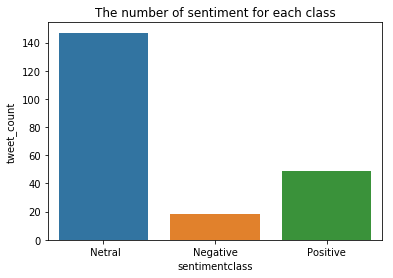

In [33]:
#make a barchar
ax = sns.barplot(x= 'sentimentclass', y='tweet_count', data=chart)
ax = ax.set_title('The number of sentiment for each class') 

#### 4.2. Pie Chart

(-1.1186405072747054,
 1.138937393289157,
 -1.1158387924009439,
 1.1272372075712869)

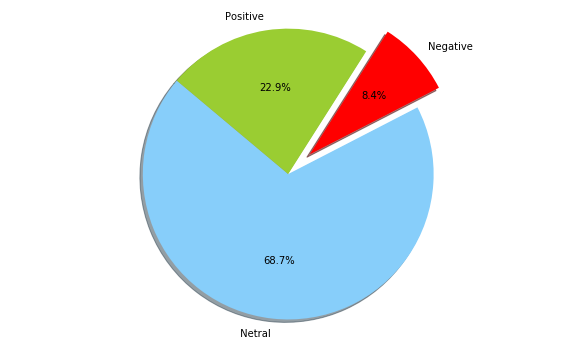

In [34]:
colors = ['lightskyblue','red','yellowgreen']
explode = (0, 0.2, 0)  # explode 1st slice
# Plot
figure = plt.figure(figsize= (10,6))
plt.pie(chart['tweet_count'], explode=explode, labels=chart['sentimentclass'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

# Sentiment Analysis

## Import Module

In [35]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
import nltk 
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andreas.rahardyanto\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preparation

In [36]:
new_df.head()

,text,sentiment,sentimentclass
0,discov googl httpstcoct01wqwbub,0.0,Netral
1,_ajami_ expect httpstcovvbswxhzsf,0.0,Netral
2,bang17287679 idiotrespond tesharakhiru aniesba...,0.0,Netral
3,yunartowijaya next,0.0,Netral
4,lidabasah back httpstcoi3grtmiajh,0.0,Netral


In [38]:
#get text and response 
data = new_df[['text','sentimentclass']]

## A. Preprocessing 

### A.1. Data Cleansing

In [39]:
#cleansing 
def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub('-\[[^]]*\]', '', text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)
    def remove_non_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

In [40]:
# #apply function 
data['text'] = data['text'].progress_apply(preprocessing)

100%|██████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 9737.37it/s]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
#stopwords.words('indonesian')

### A.2. Preprocessing

In [42]:
#stopword 
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
#lemmatization 
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### A.2. Data Exploration

In [46]:
#count sentiment 
sentiment = data.groupby(['sentimentclass'])['sentimentclass'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['sentimentclass']
chart.drop(['sentimentclass'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,sentimentclass,tweet_count,percent
0,Netral,147,0.686916
1,Negative,18,0.084112
2,Positive,49,0.228972


#### 1. Barchart

Text(0.5, 1.0, 'Sentiment Class')

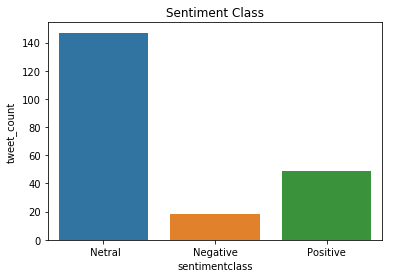

In [47]:
#visualization 
ax = sns.barplot(x='sentimentclass', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

#### 2. Wordcloud

In [50]:
#define positive and negative sentiment 
positive = data.loc[data['sentimentclass'] == "Positive"]
negative  = data.loc[data['sentimentclass'] == "Negative"]

In [52]:
#merge all the positive comments into one paragraph
all_description_positive = "".join(positive.text.values)
all_description_negative = "".join(negative.text.values)

In [53]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 100, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

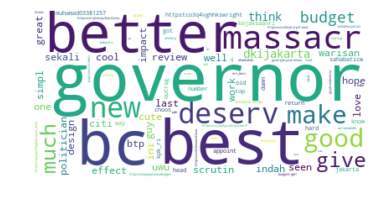

In [54]:
#positive 
create_word_cloud(all_description_positive)

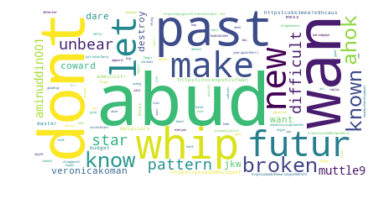

In [55]:
#negative
create_word_cloud(all_description_negative)

## B. Feature Extraction

### 1. Count Vectorizer

In [56]:
count_vectorizer = CountVectorizer(stop_words='english')

### 1. TF-IDF Vectorizer 

In [57]:
tfidf = TfidfVectorizer(stop_words='english')

## C. Modeling 

### 1. Train Test Split

In [59]:
X = data['text']
y = data['sentimentclass']

In [60]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

In [61]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

### 2. Model Machine Learning

In [62]:
# a. Logistic regression
# b. Naive Bayes

#### a. Logistic Regression

In [63]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [64]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

#### b. Naive Bayes

In [65]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [66]:
# TFIDFVectorizer
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

### 3. Model Evaluation

The following option are kind of model evaluation that used.  
- Precision = precision_score()
- Recall = recall_score() 
- F_measure = f1_score()

#### a. Logistic Regression

In [68]:
# using count vectorizer
print("______________ Countvectorizer ______________")

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 96.49% & 83.72%
Precision train & test  : 96.49% & 83.72%
F1 Score train & test   : 96.49% & 83.72%


In [69]:
# using count vectorizer
print("______________ TF-IDF ______________")

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 73.10% & 74.42%
Precision train & test  : 73.10% & 74.42%
F1 Score train & test   : 73.10% & 83.72%


#### b. Naive Bayes

In [70]:
# model evaluation for naive bayes using count vectorizer
print("______________ Countvectorizer ______________")

NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 97.08% & 69.77%
Precision train & test  : 97.08% & 69.77%
F1 Score train & test   : 97.08% & 69.77%


In [71]:
# using count vectorizer
print("______________ TF-IDF ______________")

NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 83.63% & 81.40%
Precision train & test  : 83.63% & 81.40%
F1 Score train & test   : 83.63% & 69.77%
